In [1]:
import random
import torch
import numpy as np
import pandas as pd
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize

# Set the seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4029        0.1984  0.0638
      2        0.2161        0.0884  0.0598
      3        0.1444        0.0799  0.0678
      4        0.1280        0.0699  0.0688
      5        0.1187        0.0761  0.0568
      6        0.1067        0.0679  0.0658
      7        0.0936        0.0706  0.0658
      8        0.0898        0.0675  0.0658
      9        0.0890        0.0631  0.0808
     10        0.0865        0.0662  0.0788
     11        0.0891        0.0629  0.0638
     12        0.0880        0.0616  0.0559
     13        0.0795        0.0611  0.0648
     14        0.0756        0.0601  0.0668
     15        0.0732        0.0563  0.0638
     16        0.0781        0.0680  0.0509
     17        0.0719        0.0529  0.0628
     18        0.0728        0.0614  0.0678
     19        0.0672        0.0526  0.0581
     20      

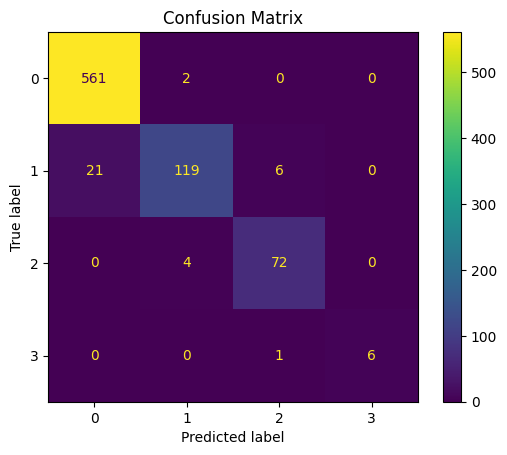

In [ ]:
train_csv_path = './data/processed_train_df.csv'
test_csv_path = './data/processed_test_df.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.float32)   # Use float32 for regression

# Test data (features only)
X_test = test_df.drop(columns=['id'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale features
])

# Define preprocessing for categorical data
#categorical_pipeline = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encode
#])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols)#,
#    ('cat', categorical_pipeline, categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer: Regression output
        layers.append(nn.Linear(layer_sizes[-1], 1))  # Output 1 value
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X).squeeze(-1)  # Output shape should be (batch_size,)

# Determine the number of input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]  # Use a small sample to get the shape

# Define the Skorch NeuralNetRegressor
net = NeuralNetRegressor(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],
    module__nonlin=nn.ReLU(),    # Default activation function
    module__dropout=0.5,         # Default dropout rate
    max_epochs=100,
    lr=0.001,
    optimizer=torch.optim.Adam,  # Default optimizer
    criterion=torch.nn.MSELoss,
    batch_size=256,
    iterator_train__shuffle=True,
    verbose=1,
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

params = {
    'nn__lr': [0.01, 0.001],
    'nn__max_epochs': [20, 50],
    'nn__module__hidden_sizes': [[128, 64], [64, 32]],
    'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
    'nn__module__dropout': [0.0, 0.5],
    'nn__optimizer': [torch.optim.Adam],
}

# Initialize GridSearchCV
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=10,                     # 10-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE for regression
    refit=True,                # Refit the model with the best parameters
    verbose=2,                 # Verbosity level
    n_jobs=-1                  # Utilize all available cores
)

# Fit the model on the training data
gs.fit(X_train, y_train)

# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation MSE: {abs(gs.best_score_):.4f}")
print(f"Best Parameters: {gs.best_params_}")

# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred_continuous = best_pipeline.predict(X_val)

# Perform threshold optimization
def threshold_rounder(y_pred_continuous, thresholds):
    return np.where(y_pred_continuous < thresholds[0], 0,
                    np.where(y_pred_continuous < thresholds[1], 1,
                             np.where(y_pred_continuous < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, y_pred_continuous):
    y_pred_discrete = threshold_rounder(y_pred_continuous, thresholds)
    return -cohen_kappa_score(y_true, y_pred_discrete, weights='quadratic')

# Initial thresholds
initial_thresholds = [0.5, 1.5, 2.5]

# Optimize thresholds
opt_result = minimize(
    evaluate_predictions,
    x0=initial_thresholds,
    args=(y_val, y_val_pred_continuous),
    method='nelder-mead'
)

optimal_thresholds = opt_result.x

# Apply optimized thresholds
y_val_pred_discrete = threshold_rounder(y_val_pred_continuous, optimal_thresholds)

# Calculate Quadratic Weighted Kappa on the validation set
val_kappa = cohen_kappa_score(y_val, y_val_pred_discrete, weights='quadratic')
print(f"\nValidation Quadratic Weighted Kappa (after threshold optimization): {val_kappa:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_discrete))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred_discrete)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Predict on the test set
y_test_pred_continuous = best_pipeline.predict(X_test)
y_test_pred_discrete = threshold_rounder(y_test_pred_continuous, optimal_thresholds)

# Save the predictions to a file
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred_discrete})
#output_df.to_csv('nn_predictions.csv', index=False)

#print("\nPredictions have been saved successfully.")

In [3]:
output_df

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,0
6,0038ba98,0
7,0068a485,0
8,0069fbed,0
9,0083e397,0
